## Indirect (shooting) method for optimal control with Jax #

**Abstract** : 
Optimal control methods have been around for quite some time with the most recent proposed methods (iLQR, DDP, SAC) been developed only recently. What is impressive about these methods is their use in robotics which has led to profound and almost human-like abilities in robot motions. In this article, I will formulate the optimal control problem and present one of the most general method for optimal control commonly referred to as the shooting method. I will also present a simple code-base using `python` and `Jax` for automatic differentiation.  

## Continuous dynamical systems with inputs

Before we get into the optimal control part, we need to set up the robot dynamics and how we are introducing control input to the robot.

Let's consider a general continuous time dynamical system (a.k.a. robot) with input of the form 

$$ 
    \dot{x}(t) = f(x(t),u(t))
$$

where $x(t) \in \mathbb{R}^n$ is the state of the dynamical system at time $t$, $u(t) \in \mathbb{R}^m$ is the control input to the dynamical system at time $t$, and $f(x, u): \mathbb{R}^{n \times m} \to \mathbb{R}^n$ is the (often nonlinear) mapping that takes the state and control and returns the instantaneous change of the state $\dot{x}\in \mathbb{R}^n$. Often, these types of dynamical systems are written using the integral form:

$$
    x(t_t) = x(t_0) + \int_{t_0}^{t_f} f(x(t), u(t) ) dt 
$$

where the integration starts at some initial condition $x(t_0)$ at time $t_0$ and integrates forward $x(t)$ onto time $t_f$. Note that this formulation assumes that $u$ and $x$ are both continuous in $t$ (same goes for $f(x,u)$, but not always true). The integration can be done using any choice of integration method (RK4, Euler, etc.).

Our first step is to import the libraries to create the dynamics that we will be working with.

In [4]:
import jax.numpy as np # imports numpy for vector-matrix math
from jax import grad, jit, vmap, jacfwd # all the derivative and gradients
from tqdm import tqdm, trange
# %matplotlib notebook
import matplotlib.pyplot as plt

For our first example, we are going to use the following nonlinear dynamical system:

$$
    \dot{x} = f(x, u) = \begin{bmatrix} -0.1 && -1.0 \\ 1.0 && -0.1 \end{bmatrix} \begin{bmatrix}  x_1^3 \\ x_2\end{bmatrix} + \begin{bmatrix} 1.0 && 0. \\ 0. && 1.0 \end{bmatrix} u
$$

where $x = \left[x_1, x_2 \right]^\top$. We will also be needing to use the derivatives with respect to the state and control $\frac{\partial f}{\partial x}, \frac{\partial f}{\partial u}$. To extract this, we will use the `jacfwd` and the `jit` functions to get the forward jacobian and then speed up the computation with `jit`.

In [5]:
@jit
def f(x, u): 
    A = np.array([[-0.1, -1.0],
                [1.0, -0.1]])
    B = np.array([[1.0, 0.],
                [0., 1.0]])
    non_lin_x = np.array([x[0]*x[0]*x[0], x[1]])
    return np.dot(A, non_lin_x) + np.dot(B, u)

# @jit
# def f(x, u):
#     p, th, pdot, thdot = x
#     thddot = 9.81 * np.sin(th) + u[0] * np.cos(th)
#     pddot = u[0]
#     return np.array([pdot, thdot, pddot, thddot])

# get the jacobians 
dfdx = jit(jacfwd(f,0))
dfdu = jit(jacfwd(f,1))

## Objectives in optimal control

Now that we have defined this dynamical system let's define the objective (a.k.a. the task)! For those familiar with reinforcement learning, this objective is equivalent to a reward function which assigns a value to the state and control. Here, we use a cost function (negative reward) that we have full knowledge of to define the task for the robot.

Let $\ell(x,u) : \mathbb{R}^{n \times m} \to \mathbb{R}$ be the running cost and let $m(x):\mathbb{R}^m \to \mathbb{R}$ be the terminal cost. Then the objective function $J(x(t), u(t))$ for $t \in \left[t_0, t_f \right]$ is defined as

$$
    \begin{align}
        & \min_{u(t)} \qquad \mathcal{J} = m(x(t_f)) + \int_{t_0}^{t_f} \ell(x(t), u(t)) dt \\
        & \text{subject to } \dot{x} = f(x(t), u(t)) \text{ and } x(t_0) = x_0
    \end{align}
$$

where we add the dynamics and the initial condition as a constraint to the objective function $\mathcal{J}$.

For the previously defined dynamical system, the following running cost and terminal cost are

$$
    \ell(x, u) = x^\top x + 0.001 u^\top u \text{ and } m(x) = x^\top x.
$$

The control sequence $u(t)$ that solve this particular optimal control problem drives the system state $x \to \mathbf{0}$.

To write this objective down, we will use the `grad` function with `jit` to get the first order derivatives of $\ell$ and $m$ ($\frac{\partial \ell}{\partial x},\frac{\partial \ell}{\partial u},\frac{\partial m}{\partial x}$) with respect to $x$ and $u$ as we will be need those functions to solve for the control problem. 

In [6]:
@jit
def ell(x, u):
    return np.dot(x, x) + 1e-3 * np.dot(u, u)

@jit
def m(x):
    return np.dot(x, x)

dldx, dldu = jit(grad(ell, 0)), jit(grad(ell, 1))
dmdx = jit(grad(m))


## The Maximum Principle (derived from the Variational derivative)

While it is possible to solve the optimal control problem drectly, discretizing in time and imposing the dynamic constriants will ultimately increase computational costs as the discretization becomes finer and the dynamics more complex. Therefore, we will solve this optimal control problem *indirectly* using the Maximum Principle to solve a set of conditions which are met when there is a minima to the objective function. The way we are going to acquire these conditions is through the variational derivative.

### Variational Derivative

Assume that $\ell(x,u)$, $m(x)$ are both continuous as differentiable functions.
In addition, let's rewrite the objective using the Lagrange multiplier $\rho(t)$ for the dynamic constraint $\dot{x} = f(x,u)$.

$$
    \mathcal{J} = m(x(t_f)) + \int_{t_0}^{t_f} \ell(x(t), u(t)) 
    + \rho(t)^\top\left( \dot{x}(t) - f(x(t), u(t) \right) dt
$$

Since $\mathcal{J}$ is continuous in $x, u$ and $t$ then we can take the variational derivative of $\mathcal{J}$ with respect to $x$ and $u$. This derivative is defined as 

$$
    \delta \mathcal{J} = D \mathcal{J} \cdot \delta v = m_x^\top \delta x(t_f) 
        + \int_{t_0}^{t_f} \ell_x^\top \delta x 
        + \ell_u^\top \delta u + \rho^\top f_x \delta x 
        + \rho^\top f_u \delta u - \rho^\top \delta \dot{x} dt.
$$

where $\delta v = \left[\delta x, \delta u \right]^\top$ is the variation in the state $\delta x$ and control $\delta u$, $D \mathcal{J}$ is the variational derivative of $\mathcal{J}$ with respect to $x$ and $u$, and the subscripts denote derivatives terms (i.e., $m_x = \frac{\partial m}{\partial x})$.

Note that the term on the right can be evaluated using integration by parts
$$
    -\int_{t_0}^{t_f} \rho^\top \delta\dot{x} dt = - \rho(t_f)^\top \delta x(t_f) + \rho(t_0)^\top \delta x(t_0) + \int_{t_0}^{t_f} \dot{\rho}^\top \delta x dt
$$

therefore the variation $\delta \mathcal{J}$ becomes

$$
    \delta \mathcal{J}  = m_x(x(t_f))^\top \delta x(t_f) 
            + \int_{t_0}^{t_f} (\ell_u^\top  + \rho^\top f_u) \delta u dt
            + \int_{t0}^{t_f} (\ell_x^\top + \rho^\top f_x + \dot{\rho}^\top) \delta x dt 
            - \rho(t_f)^\top \delta x(t_f) + \rho(t_0)^\top \delta x(t_0)
$$

### Necessary conditions for optimality (Pontryagin's maximum principle)

What is fascinating about $\delta \mathcal{J}$ is that it is split up into three parts: state variation $\delta x$, control variation $\delta u$ and boundary conditions $\delta x(t_0), \delta x(t_f)$. If each of these portions of the variation are equal to zero (i.e., $\delta \mathcal{J} = 0$), that would suggest that the solution $u(t), x(t)$ is at a optimum for the objective function (think of taking the gradient of a function and setting the gradient equal to zero to solve the objective). Since we know how to solve this type of optimization problem, let's set each component equal to zero and try to solve the system of equations

$$
\begin{align}
    \ell_u + f_u^\top \rho  & = 0 \\
    \ell_x + f_x^\top \rho + \dot{\rho} &  = 0 \\ 
    m_x(x(t_f)) - \rho(t_f)  & = 0
\end{align}
$$

Note that the last two conditions define the following differential equation

$$
\begin{align}
     & \dot{\rho} = - \ell_x - f_x^\top \rho \\
     & \text{ subject to } \rho(t_f) = m_x (x(t_f))
\end{align}
$$

which is solved backwards in time (starting from the boundary condition $x(t_f) = m_x$. Note that we assume that $x(t_0)$ does not change, therefore the variation $\delta x(t_0) = 0$.

Now if you think deeply about the set of equations, we can see that these conditions make a pretty powerful statement! We can propose a sequence of controls $u(t)$ and evaluate if it is suboptimal through evaluating these equations. The more interesting question is how exactly can we get $u(t)$ such that the optimality conditions are met from the system of equations?

Here is where we get to the interesting part (and where all the derivative terms we initially constructed come into play. Let's try to solve the system of equations given an initial guess of $u(t)$ and iteratively upate that initial guess.

### Shooting method

To solve this kind of problem you first need to see what the resulting trajectory $x(t)$ is given the control sequence $u(t)$. Then you calculate the boundary condition (i.e., $\rho(t_f)$) and solve the second equation backwards in time. The first equation tells us the condition that the control has to satisfy, and as it turns out is the exact solution to the gradient of the control at each instance in time (if you write out the control Hamiltonian you can see it for yourself). This procedure is then the start of the shooting method for solving optimal control problems.

The iterative algorithm goes as follows: 

Given $x_0$ set an arbitrary $u(t)$ for $t \in \left[t_0, t_f \right]$ loop the following
1. forward simulate $x_0$ using $\dot{x} = f(x, u)$ for time $t_0 \to t_f$. (forward pass)
2. evaluate $m_x(x(t_f))$ and simulate the Lagrange multiplier $\rho(t)$ backwards in time starting from $\rho(t_f) = m_x(x(t_f))$ (backward pass)
3. at each time step, let $\delta u = - \gamma ( \ell_u + f_u^\top \rho)$ where $\gamma$ is the step size for the contol gradient
4. let $u = u + \delta u$
* repeat until $\delta u$ is near zero.

We will code this algorithm in two parts, the forward pass and the backward pass that takes in the derivative terms that we calculated and the candidate set of controls. 

In [22]:
def forward_pass(x_0, u, dt=0.01):
    x    = []
    x_t  = x_0.copy()
    cost = 0.0
    for t, u_t in enumerate(u): 
        x.append(x_t)
        cost += ell(x_t, u_t) * dt
        x_t = x_t + f(x_t, u_t) * dt
    return x, cost, x_t

def backward_pass(x, u, x_f, dt=0.01, step_size=1e-1):
    u_star = []
    costate = []
    rho = dmdx(x_f)
    for x_t, u_t in zip(x[::-1], u[::-1]):
        costate.append(rho)
        rho_dot = - dldx(x_t, u_t) - np.dot(dfdx(x_t, u_t).T, rho)
        rho = rho - rho_dot * dt
        du = dldu(x_t, u_t) + np.dot(dfdu(x_t, u_t).T, rho)
        u_star.append(u_t - step_size * du)
    costate.append(rho)
    return u_star[::-1], costate[::-1]

We are going to first initialize some parameters and also discretize time (we are going to use Euler integration, but any integration scheme will work)

In [34]:
# some parameters 
max_iter  = 100
tf        = 2
dt        = 0.1 # time step
N         = int(tf/dt)
threshold = 0.001
step_size = 1e-2

# initialize the control with a random sequence of actions
u = [np.array([.1, -.1]) * np.sin(t*0.1) for t in range(N)]
x0 = np.array([-2.1,1.0]) # initial condition

In [35]:
trajectories = []
costates = []
costs = []
with tqdm(total=max_iter) as pbar:
    for k in range(max_iter):
        x, cost, x_f = forward_pass(x0, u, dt)
        u, costate = backward_pass(x, u, x_f, dt, step_size)
        x, cost, x_f = forward_pass(x0, u, dt)
        cost += m(x_f)
        pbar.set_description('Current Cost: {}'.format(cost))
        pbar.update()
        if k % 20 == 0:
            trajectories.append(x)
            costs.append(cost)
            costates.append(costate)

Current Cost: 1.2003618478775024: 100%|██████████| 100/100 [00:05<00:00, 19.67it/s]


Let's visualize what this looks like!

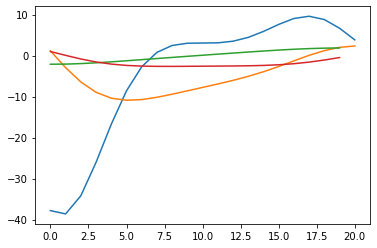

In [36]:
plt.plot(costates[0])
plt.plot(trajectories[0])

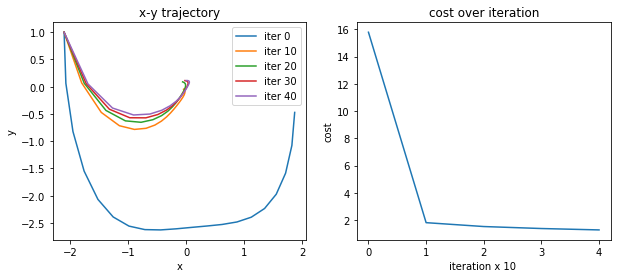

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, x in enumerate(trajectories):
    x = np.stack(x)
    axs[0].plot(x[:,0], x[:,1], label='iter {}'.format(i*10))
#     axs[0].plot(x[:,1], label='iter {}'.format(i*10))
axs[1].plot(np.stack(costs), label='iter {}'.format(i*10))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('x-y trajectory')
axs[0].legend()
axs[1].set_xlabel('iteration x 10 ')
axs[1].set_ylabel('cost')
axs[1].set_title('cost over iteration')
plt.savefig('indirect-opt-control-ex1.png')
plt.show()

We can see that each step works towards improving the cost function and completing the task. You can use this formation for almost any problem so long as it is not an impossible task and the system has continuous derivatives. Many of the most common optimal controllers and trajectory planners (like iLQR) work in similar manner with a forward and backward pass

Let's updating system with a different task. Here, we will use the planar vertical takeoff-and-landing vehicle (vtol) with the task of doing a backflip. The dynamics of the vtol are given by

$$
    \frac{d}{dt}\begin{bmatrix} x \\ y \\ \theta \\ \dot{x} \\ \dot{y} \\ \dot{\theta}\end{bmatrix} 
    = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \\ -u_1 \sin (\theta) + \epsilon u_2 \cos (\theta) \\ u_1 \cos (\theta) + \epsilon u_2 \sin (\theta) - g \\ u_2\end{bmatrix}
$$

where $g$ is gravity and $\epsilon \in [0, 1]$ represents the coupling between rolling and side movements which we set as $0.5$ .

Let's get this vtol to flip which we will define as the following objective function 

$$
    \ell(s,u) = 0.001 u^\top u \qquad m(s) = (s - s_d)^\top Q (s - s_d)^\top
$$

where $s = \left[ x, y, \theta, \dot{x}, \dot{y}, \dot{\theta} \right]^\top$, $s_d = \left[ 4, 0, 2 \pi, 0, 0, 0 \right]^\top$, $u = \left[ u_1, u_2 \right]^\top$, and  $Q = \text{diag}\left( 1, 1, 20, 0.1, 0.1, 20\right)$. Below we write this out in the same way we wrote the model (overriding the first example) and the objective in the first example.

In [9]:
@jit
def f(s, a):
    eps = 0.5
    x, y, th, xt, yt, tht = s
    u1, u2 = a
    xtt = - u1 * np.sin(th) + eps * u2 * np.cos(th)
    ytt = u1 * np.cos(th) + eps * u2 * np.sin(th) - 9.81
    thtt = u2
    return np.array([xt, yt, tht, xtt, ytt, thtt])

@jit
def ell(x, u):
    return 1e-4 * np.dot(u, u)
@jit
def m(x):
    target = np.array([4, 0., 2.0 * np.pi, 0., 0.0, 0.])
    weights = np.array([1.0, 1.0, 20., 0.1, 0.1, 20.])
    dx = x - target
    return np.sum(np.square(dx) * weights)

dfdx, dfdu = jit(jacfwd(f, 0)), jit(jacfwd(f, 1))
dldx, dldu = jit(grad(ell)), jit(grad(ell, 1))
dmdx = jit(grad(m))


We reinitialize the environment and updated the parameters and the initial seed $u(t)$. You should play with these parameters to see their effect on the resulting control signal and the state. 

In [10]:
# some parameters 
max_iter  = 1000
dt        = 0.1
tf        = 3
N         = int(tf/dt)
threshold = 0.01
step_size = 3e-4

# initialize the control with a random sequence of actions
u = [np.array([15., .2]) for t in range(N)]
x0 = np.array([0., 0., 0., 0., 0., 0.])

In [11]:
trajectories = []
costs = []
with tqdm(total=max_iter) as pbar:
    for k in range(max_iter):
        x, cost, x_f = forward_pass(x0, u, dt)
        u = backward_pass(x, u, x_f, dt, step_size)
        cost += m(x_f)        

        if k % 20 == 0:
            trajectories.append(x)
            costs.append(cost)
            pbar.set_description('Current Cost: {:.4}'.format(cost))
            pbar.update(20)

Current Cost: 4.869: 100%|██████████| 1000/1000 [01:02<00:00, 16.02it/s]  


This part is optional, but if you wanted to see a visualization of the vtol backflip, checkout the jupyter notebook and run the following two cells. 

In [12]:
from vtol import VTOLEnv
import time
env = VTOLEnv()

In [14]:
env.reset()
for u_t in u:
    env.step(u_t)
    env.render()
    time.sleep(1/10)

Here we are going to visualize the trajectories from sim and plot the cost over each iteration.

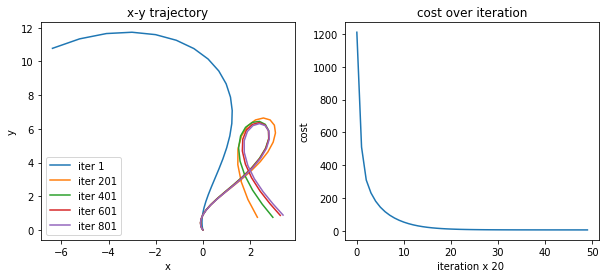

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, x in enumerate(trajectories[1::10]):
    x = np.stack(x)
    axs[0].plot(x[:,0], x[:,1], label='iter {}'.format(i*20*10+1))
axs[1].plot(np.stack(costs), label='iter {}'.format(i*10))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('x-y trajectory')
axs[0].legend()
axs[1].set_xlabel('iteration x 20 ')
axs[1].set_ylabel('cost')
axs[1].set_title('cost over iteration')
plt.savefig('indirect-opt-control-ex2.png')

plt.show()

## Modeling errors -- Sim-to-Sim examples 

With the popularity of sim-to-real methods I thought it might be interesting to show how model-mismatch would affect sim-to-sim transfer of this optimal control technique as this was common practice in earlier robotics research. Since we have the vtol environment, we can update the `eps` property in the environment class changing the $\epsilon$ parameter. We can then run the already calculated control sequence on the vtol for backfliping to compare. I encourage the reader to play with this as much as they want in the full Jupyter notebook that was used to create this post!

In [16]:
env.eps = 0.5
env.reset()
exact_trajectory = []
for u_t in u:
    state = env.step(u_t)
    exact_trajectory.append(state)
    env.render()
    time.sleep(1/10)

env.eps = 0.8
env.reset()
mm_trajectory = [] # model mismatch
for u_t in u:
    state = env.step(u_t)
    mm_trajectory.append(state)
    env.render()
    time.sleep(1/10)

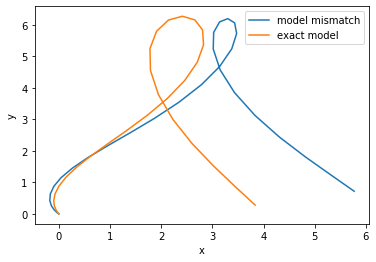

In [18]:
mm_trajectory = np.stack(mm_trajectory)
exact_trajectory = np.stack(exact_trajectory)
plt.plot(mm_trajectory[:,0], mm_trajectory[:,1], label='model mismatch')
plt.plot(exact_trajectory[:,0], exact_trajectory[:,1], label='exact model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('indirect-opt-control-ex3.png')

plt.show()

## Concluding remarks

You can see that the slight deviation from the exact model causes the generated trajectories to deviate which results in the robot ending up at a different target point. Often in earlier robotics research, this model-mismatch was often solved using system identification to improve the quality of the model using real-world data. Although, often it is not possible to get such data without having the robot execute dangerous movements that may break. This will be the talking point for the next post on receding horizon control! Hope you enjoyed the post and if you find this helpful in anyway please cite me and follow my research!

Please Cite this if you've found it useful and interesting! 
```
@article{abraham2020indirectoptimalcontrol,
  title   = "Introduction to Indirect Optimal Control",
  author  = "Abraham, Ian",
  journal = "i-abr.github.io/bloggy-blog",
  year    = "2020",
  url     = "https://i-abr.github.io/bloggy-blog/"
```